In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

print(os.listdir("/content/drive/MyDrive"))


['AIDriven Archaeological Site Mapping', 'FirstName_LastName_Resume (1).docx', "Swati Yadav's wedding ceremony ", 'project.pdf', 'Screenshot_20250227_103459.jpg', 'Untitled presentation (1).gslides', 'Untitled presentation.gslides', 'Colab Notebooks', 'bug-detection-transformers.ipynb', 'bug-repair-transformers.ipynb', 'codenetpy_test.json', 'codenetpy_train.json', 'BugDetectionProject', 'cen_profile.png', 'Certificate', 'Shreyansh Yadav.docx', 'Shreyansh Yadav (1).docx', 'shre3250_67b763b56ff27.docx', 'IMG-20250512-WA0025.jpg', 'Mini Task 1.gdoc', 'Mini Task 1.docx', 'Screenshot 2025-06-11 220501.png', 'Document from Shreyansh Yadav', 'vnd.openxmlformats-officedocument.presentationml.presentation&rendition=1.pptx', 'BWU_BTA_22_192 (1).pptx', 'BWU_BTA_22_192.pptx', 'Screenshot 2025-06-22 134053.png', 'Project_Report_Shreyansh_Yadav.pdf', 'video_20250627_193656.mp4', 'Copy of King Kohli PPT.pptx', 'Screenshot_20250703_131735 (1).jpg', 'Screenshot_20250703_131735.jpg', 'test.gdoc', 'Supe

In [ ]:
BASE_PATH = "/content/drive/MyDrive/AIDriven Archaeological Site Mapping/my_dataset"

import os
print(os.listdir(BASE_PATH))
print(os.listdir(BASE_PATH + "/train"))
print(os.listdir(BASE_PATH + "/train/images")[:5])


['val', 'train']
['images', 'masks']
['23429080_15.png', '22828930_15.png', '23429020_15.png', '22829050_15.png', '23579005_15.png']


In [ ]:
print("Train images:", len(os.listdir(BASE_PATH + "/train/images")))
print("Train masks :", len(os.listdir(BASE_PATH + "/train/masks")))
print("Val images  :", len(os.listdir(BASE_PATH + "/val/images")))
print("Val masks   :", len(os.listdir(BASE_PATH + "/val/masks")))


Train images: 21
Train masks : 21
Val images  : 4
Val masks   : 4


In [ ]:
import os
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [ ]:
class SegDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.files = os.listdir(img_dir)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.files[idx])
        mask_path = os.path.join(self.mask_dir, self.files[idx])

        img = cv2.imread(img_path)
        img = cv2.resize(img, (256, 256))
        img = torch.tensor(img).permute(2, 0, 1) / 255.0

        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (256, 256))
        mask = torch.tensor(mask > 0).float()

        return img, mask


In [ ]:
train_ds = SegDataset(
    BASE_PATH + "/train/images",
    BASE_PATH + "/train/masks"
)

val_ds = SegDataset(
    BASE_PATH + "/val/images",
    BASE_PATH + "/val/masks"
)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=2)


In [ ]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        x = self.encoder(x)
        return torch.sigmoid(self.decoder(x))


In [ ]:
device = "cpu"   # GPU ho to "cuda"

model = SimpleUNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 10

for epoch in range(EPOCHS):
    # ---- TRAIN ----
    model.train()
    train_loss = 0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds.squeeze(1), masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # ---- VALIDATION ----
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = criterion(preds.squeeze(1), masks)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1/10 | Train Loss: 0.6769 | Val Loss: 0.6092
Epoch 2/10 | Train Loss: 0.5770 | Val Loss: 0.4850
Epoch 3/10 | Train Loss: 0.5087 | Val Loss: 0.4330
Epoch 4/10 | Train Loss: 0.5056 | Val Loss: 0.4279
Epoch 5/10 | Train Loss: 0.4960 | Val Loss: 0.4290
Epoch 6/10 | Train Loss: 0.4833 | Val Loss: 0.4271
Epoch 7/10 | Train Loss: 0.4774 | Val Loss: 0.4151
Epoch 8/10 | Train Loss: 0.4708 | Val Loss: 0.4085
Epoch 9/10 | Train Loss: 0.4633 | Val Loss: 0.4065
Epoch 10/10 | Train Loss: 0.4560 | Val Loss: 0.3962


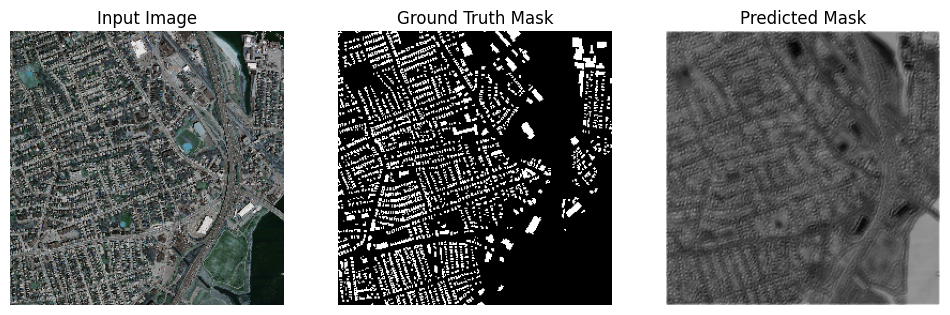

In [ ]:
model.eval()
img, mask = val_ds[0]

with torch.no_grad():
    pred = model(img.unsqueeze(0)).squeeze().numpy()

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(img.permute(1,2,0))
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Ground Truth Mask")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(pred, cmap="gray")
plt.axis("off")

plt.show()


In [ ]:
import os
import cv2

IMG_DIR = BASE_PATH + "/train/images"
MASK_DIR = BASE_PATH + "/train/masks"
LABEL_DIR = "/content/yolo_dataset/labels/train"

os.makedirs(LABEL_DIR, exist_ok=True)

for file in os.listdir(MASK_DIR):
    mask_path = os.path.join(MASK_DIR, file)
    img_path = os.path.join(IMG_DIR, file)

    mask = cv2.imread(mask_path, 0)
    h, w = mask.shape

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    yolo_lines = []
    for cnt in contours:
        x, y, bw, bh = cv2.boundingRect(cnt)

        xc = (x + bw / 2) / w
        yc = (y + bh / 2) / h
        bw /= w
        bh /= h

        class_id = 0  # single class
        yolo_lines.append(f"{class_id} {xc} {yc} {bw} {bh}")

    with open(os.path.join(LABEL_DIR, file.replace(".png", ".txt")), "w") as f:
        f.write("\n".join(yolo_lines))


In [ ]:
import shutil

DST_IMG = "/content/yolo_dataset/images/train"
os.makedirs(DST_IMG, exist_ok=True)

for f in os.listdir(BASE_PATH + "/train/images"):
    shutil.copy(
        BASE_PATH + "/train/images/" + f,
        DST_IMG + "/" + f
    )


In [ ]:
data = """
path: /content/yolo_dataset
train: images/train
val: images/train

nc: 1
names: ['structure']
"""

with open("/content/yolo_dataset/data.yaml", "w") as f:
    f.write(data)


In [ ]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.1 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # lightweight
model.train(
    data="/content/yolo_dataset/data.yaml",
    epochs=20,
    imgsz=640,
    batch=4
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b4f38b09880>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 